In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [52]:
url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv"
housing_df = pd.read_csv(url)
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


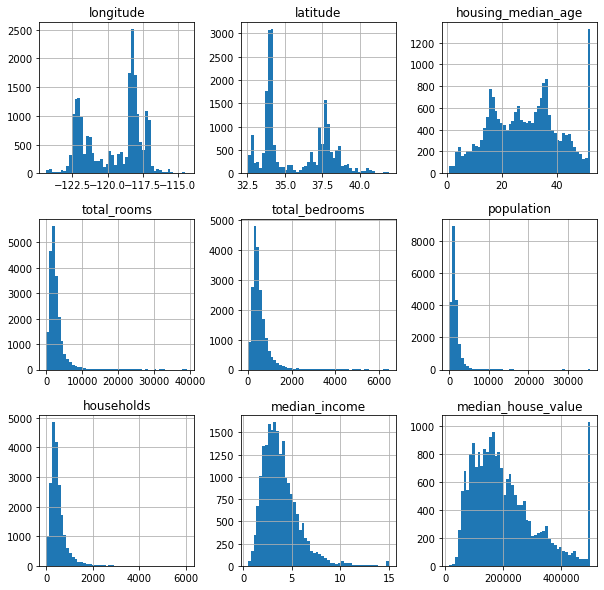

In [53]:
housing_df.hist(bins=50,figsize=(10,10))
plt.show()

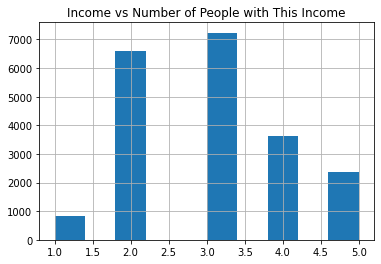

In [54]:
housing_df["income_cat"] = pd.cut(housing_df["median_income"],bins=[0.,1.5,3.,4.5,6.,np.inf],labels=[1,2,3,4,5]) #1.5 equals to $15 000 6 equals to $600 000 etc.
housing_df["income_cat"].hist()
plt.title("Income vs Number of People with This Income")
plt.show()

In [55]:
#STEP 1: prepare the train and test data sets randomly with 20% test 80% train data
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index, test_index in split.split(housing_df,housing_df["income_cat"]):
    train_set = housing_df.loc[train_index]
    test_set = housing_df.loc[test_index]
train_set.drop("income_cat",axis=1,inplace=True)
test_set.drop("income_cat",axis=1,inplace=True)

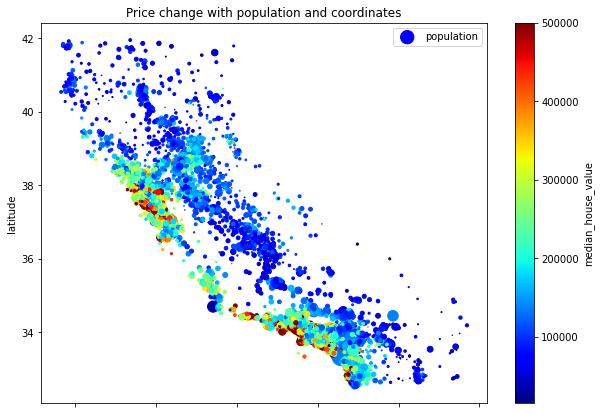

In [57]:
housing_df = train_set.copy()
housing_df.plot(kind="scatter",
               x="longitude",
               y="latitude",
               s=train_set["population"]/100,
               label="population",
               figsize=(10,7),
               c="median_house_value",
               cmap=plt.get_cmap("jet"),
               colorbar=True)
plt.title("Price change with population and coordinates")
plt.legend()

In [58]:
housing_df["rooms_per_household"] = housing_df["total_rooms"]/housing_df["households"]
housing_df["bedrooms_per_room"] = housing_df["total_bedrooms"]/housing_df["total_rooms"]
housing_df["population_per_household"]=housing_df["population"]/housing_df["households"]
corr_matrix = housing_df.corr()
print("how prices correlates with other attributes")
corr_matrix["median_house_value"].sort_values(ascending=False)

how prices correlates with other attributes


/var/folders/23/0kf9cxz57zd2dvfgn6pd8yw80000gn/T/ipykernel_25024/2254320276.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing_df.corr()


median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

In [63]:
#STEP 2: prepare the data
housing_df = train_set.drop("median_house_value", axis=1)
housing_actual = train_set["median_house_value"].copy()
housing_numerical = housing_df.drop("ocean_proximity", axis=1)
housing_cat = housing_df[["ocean_proximity"]]
#custom transformation class
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
numerical_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                               ('attribs_adder',CombinedAttributesAdder()),
                               ('std_scaler',StandardScaler())])
full_pipeline = ColumnTransformer([
    ("num",numerical_pipeline,list(housing_numerical)),
    ("cat",OneHotEncoder(),["ocean_proximity"])])

housing_prepared = full_pipeline.fit_transform(housing_df)

In [76]:
#STEP 3: train the model
#LINEAR REGRESSION
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_actual)
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_actual,housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print("prediction error for linear regression is $%.2f" % lin_rmse)

prediction error for linear regression is $68627.87


In [78]:
#DECISION TREE REGRESSOR
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared,housing_actual)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_actual,housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print("prediction error for decision tree regression is $%.2f" % tree_rmse)

prediction error for decision tree regression is $0.00


In [91]:
#RANDOM FOREST TREE REGRESSOR
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared,housing_actual)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_actual,housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print("prediction error for random forest tree regression is $%.2f" % forest_rmse)

prediction error for random forest tree regression is $18713.37


In [94]:
#K-FOLD CROSS VALIDATION
scores = cross_val_score(tree_reg,housing_prepared,housing_actual,scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
print("DECISION TREE CROSS REGRESSION VALIDATION")
print("prediction errors for 10 evaluation", np.round(tree_rmse_scores,2))
print("mean prediction error $%.2f" % tree_rmse_scores.mean())
print("standard deviation of errors $%.2f" % tree_rmse_scores.std())
print("\n")
lin_scores = cross_val_score(lin_reg,housing_prepared,housing_actual,scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
print("LINEAR REGRESSION CROSS VALIDATION")
print("prediction errors for 10 evaluation", np.round(lin_rmse_scores,2))
print("mean prediction error $%.2f" % lin_rmse_scores.mean())
print("standard deviation of errors $%.2f" % lin_rmse_scores.std())
print("\n")
forest_scores = cross_val_score(forest_reg,housing_prepared,housing_actual,scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
print("RANDOM FOREST REGRESSION CROSS VALIDATION")
print("prediction errors for 10 evaluation", np.round(forest_rmse_scores,2))
print("mean prediction error $%.2f" % forest_rmse_scores.mean())
print("standard deviation of errors $%.2f" % forest_rmse_scores.std())

DECISION TREE CROSS REGRESSION VALIDATION
prediction errors for 10 evaluation [72687.43 69501.65 69670.93 72232.72 70408.06 77731.4  70592.61 72020.4
 68434.75 70692.16]
mean prediction error $71397.21
standard deviation of errors $2456.53


LINEAR REGRESSION CROSS VALIDATION
prediction errors for 10 evaluation [71762.76 64114.99 67771.17 68635.19 66846.14 72528.04 73997.08 68802.34
 66443.29 70139.8 ]
mean prediction error $69104.08
standard deviation of errors $2880.33


RANDOM FOREST REGRESSION CROSS VALIDATION
prediction errors for 10 evaluation [51653.63 48872.31 47037.68 52188.79 47292.25 51582.2  52359.06 49734.51
 48565.38 53507.5 ]
mean prediction error $50279.33
standard deviation of errors $2159.25


In [97]:
#STEP 4: find the best estimator GridSearchCV
parameter_grid = [
    {'n_estimators':[3,10,30], 'max_features':[2,4,6,8]}, {'bootstrap':[False], 'n_estimators':[3,10], 'max_features':[2,3,4]}
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid=parameter_grid,cv=5, scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(housing_prepared, housing_actual)
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [98]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [99]:
grid_search.cv_results_

{'mean_fit_time': array([0.06922221, 0.19050241, 0.56596179, 0.09080024, 0.29751458,
        0.92299471, 0.13931623, 0.4328433 , 1.21971188, 0.15451932,
        0.52095032, 1.56477718, 0.07997913, 0.26269374, 0.11009316,
        0.34972162, 0.12954259, 0.43999872]),
 'std_fit_time': array([0.00913506, 0.00169024, 0.0169265 , 0.00438919, 0.01774047,
        0.01752692, 0.02290926, 0.01844652, 0.01192858, 0.00180229,
        0.0101721 , 0.01791402, 0.00163144, 0.00382124, 0.00920901,
        0.01008155, 0.00196335, 0.01760064]),
 'mean_score_time': array([0.00409856, 0.00886655, 0.02484822, 0.00281224, 0.00784783,
        0.02464147, 0.00331163, 0.00913415, 0.02275877, 0.00292139,
        0.00827379, 0.02290769, 0.0033741 , 0.00913095, 0.00327549,
        0.00923176, 0.00321941, 0.00920501]),
 'std_score_time': array([0.00069049, 0.00064061, 0.00197391, 0.0001025 , 0.00021412,
        0.00397898, 0.00026778, 0.00101222, 0.00043751, 0.00017746,
        0.00071969, 0.00155788, 0.00018782, 

In [115]:
#SUPPORT VECTOR MACHINE REGRESSOR
parameter_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]
svr = SVR()
grid_search = GridSearchCV(svr, param_grid=parameter_grid,cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_actual)
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

In [100]:
#STEP 5: Test the best estimator model with test data set
model = grid_search.best_estimator_

X_test = test_set.drop("median_house_value",axis=1)
y_test = test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
predictions = model.predict(X_test_prepared)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print("Best estimator: ", model)
print("predicted error value for this estimator $%.2f" % rmse)

Best estimator:  RandomForestRegressor(max_features=6, n_estimators=30)
predicted error value for this estimator $48118.73
